In [1]:
import matplotlib.pyplot as plt

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# Set manual seed for reproducibility
torch.manual_seed(1)
np.random.seed(1)

# Generate synthetic data for XOR problem
# Generate 200 samples of 2D data points uniformly distributed between -1 and 1 for both features.
x = np.random.uniform(low=-1, high=1, size=(200, 2))
# Label these points with 0 or 1 based on the XOR rule: a point is labeled 1 if either both x and y are positive or both are negative; otherwise, it is labeled 0.
y = np.ones(len(x))
y[np.logical_and(x[:, 0] < 0, x[:, 1] < 0)] = 0
y[np.logical_and(x[:, 0] > 0, x[:, 1] > 0)] = 0

print(x.shape)
print(y.shape)
print(x[:2])

(200, 2)
(200,)
[[-0.16595599  0.44064899]
 [-0.99977125 -0.39533485]]


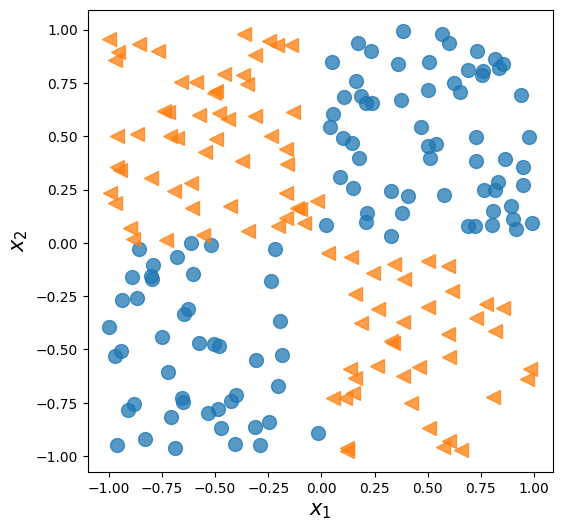

In [3]:
# Plot the data
fig = plt.figure(figsize=(6, 6))
plt.plot(x[y==0, 0], x[y==0, 1], 'o', alpha=0.75, markersize=10)
plt.plot(x[y==1, 0], x[y==1, 1], '<', alpha=0.75, markersize=10)
plt.xlabel(r'$x_1$', size=15)
plt.ylabel(r'$x_2$', size=15)
plt.show()

In [4]:
# Split the data into training and validation sets
# Turn numpy into tensors
n_train = 100
x_train_ts = torch.tensor(x[:n_train, :], dtype=torch.float32)
y_train_ts = torch.tensor(y[:n_train], dtype=torch.float32)
x_valid_ts = torch.tensor(x[n_train:, :], dtype=torch.float32)
y_valid_ts = torch.tensor(y[n_train:], dtype=torch.float32)

print(x_train_ts.shape)
print(y_train_ts.shape)
print(x_train_ts[:2])
print(y_train_ts[:2])

torch.Size([100, 2])
torch.Size([100])
tensor([[-0.1660,  0.4406],
        [-0.9998, -0.3953]])
tensor([1., 0.])


In [5]:
# Define the model
model = nn.Sequential(
    nn.Linear(2, 1),
    nn.Sigmoid()
)

In [6]:
# Initialize the binary cross-entropy loss
loss_fn = nn.BCELoss()

# Initialize the SGD optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [7]:
# Define the train dataset
train_ds = TensorDataset(x_train_ts, y_train_ts)

In [31]:
def fit_model(model: torch.nn.Module,
                train_ds: TensorDataset,
                loss_fn: nn.Module,
                optimizer: optim.Optimizer,
                x_valid: torch.Tensor = None,
                y_valid: torch.Tensor = None,
                accuracy_fn = None,
                num_epochs = 100,
                batch_size = 32,
                seed = 1,
                transform_pred = None,
                device: torch.device = "cpu"):
    # variables
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs    
    torch.manual_seed(seed)
    train_dl = DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True)
    n_train = len(train_dl.dataset)
    # set model to device
    model.to(device)
    for epoch in range(num_epochs):
        # set model to training mode
        model.train()
        # mini-batch training
        for x_batch, y_batch in train_dl:
            # Send data to device
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # Forward pass
            y_pred = model(x_batch)
            if transform_pred:
                y_pred = transform_pred(y_pred)

            # Compute loss
            loss = loss_fn(y_pred, y_batch)

            # Do backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            accuracy_batch = 0
            if accuracy_fn:
                accuracy_batch = accuracy_fn(y_pred, y_batch)
            loss_hist_train[epoch] += loss.item()
            accuracy_hist_train[epoch] += accuracy_batch

        # Compute store loss and accuracy as percent
        loss_hist_train[epoch] /= n_train
        accuracy_hist_train[epoch] /= n_train
        
        if x_valid is not None and y_valid is not None:
            n_valid = len(y_valid)
            # set model to training mode
            model.eval()
            with torch.no_grad():
                x_valid, y_valid = x_valid.to(device), y_valid.to(device)
                y_valid_pred = model(x_valid)
                if transform_pred:
                    y_valid_pred = transform_pred(y_valid_pred)
                loss = loss_fn(y_valid_pred, y_valid)

                accuracy_valid = 0
                if accuracy_fn:
                    accuracy_valid = accuracy_fn(y_valid_pred, y_valid)
                loss_hist_valid[epoch] = loss.item()
                accuracy_hist_valid[epoch] = accuracy_valid / n_valid
                    
        # Print out
        if epoch % 10 == 0:
            if x_valid is not None and y_valid is not None:
                print(f"Train loss: {loss_hist_train[epoch]:.5f} | Train accuracy: {accuracy_hist_train[epoch]:.2f}% | Val loss: {loss_hist_valid[epoch]:.5f} | Val accuracy: {accuracy_hist_valid[epoch]:.2f}%")
            else:
                print(f"Train loss: {loss_hist_train[epoch]:.5f} | Train accuracy: {accuracy_hist_train[epoch]:.2f}%")

    # Return result    
    return (loss_hist_train, accuracy_hist_train, loss_hist_valid, accuracy_hist_valid)

In [9]:
def accuracy_sum_binaryclass_fn(y_pred, y, threshold = 0.5):
    is_correct = ((y_pred >= threshold).float() == y).float()
    return is_correct.sum()

def transform_pred_binary(y_pred):
    return y_pred.squeeze()

In [10]:
loss_hist_train, accuracy_hist_train, loss_hist_valid, accuracy_hist_valid = fit_model(model, 
    train_ds, 
    loss_fn, 
    optimizer,
    x_valid_ts,
    y_valid_ts,
    batch_size=2,
    num_epochs = 200,
    accuracy_fn=accuracy_sum_binaryclass_fn,
    transform_pred=transform_pred_binary)

Train loss: 0.35833 | Train accuracy: 0.62% | Val loss: 0.00719 | Val accuracy: 0.57%
Train loss: 0.35699 | Train accuracy: 0.62% | Val loss: 0.00716 | Val accuracy: 0.59%
Train loss: 0.35577 | Train accuracy: 0.62% | Val loss: 0.00713 | Val accuracy: 0.59%
Train loss: 0.35468 | Train accuracy: 0.62% | Val loss: 0.00711 | Val accuracy: 0.59%
Train loss: 0.35367 | Train accuracy: 0.62% | Val loss: 0.00709 | Val accuracy: 0.58%
Train loss: 0.35276 | Train accuracy: 0.64% | Val loss: 0.00707 | Val accuracy: 0.58%
Train loss: 0.35192 | Train accuracy: 0.65% | Val loss: 0.00705 | Val accuracy: 0.59%
Train loss: 0.35116 | Train accuracy: 0.65% | Val loss: 0.00703 | Val accuracy: 0.58%
Train loss: 0.35045 | Train accuracy: 0.68% | Val loss: 0.00701 | Val accuracy: 0.59%
Train loss: 0.34982 | Train accuracy: 0.68% | Val loss: 0.00700 | Val accuracy: 0.62%
Train loss: 0.34923 | Train accuracy: 0.66% | Val loss: 0.00698 | Val accuracy: 0.64%
Train loss: 0.34870 | Train accuracy: 0.64% | Val loss

In [11]:
def plot_learning_curve(loss_hist_train, accuracy_hist_train, loss_hist_valid = None, accuracy_hist_valid = None, loss_title='Loss', accuracy_title='Accuracy'):
    # Visualization setup
    loss_legend = ['Train Loss']
    acc_legend = ['Train Acc']
    fig = plt.figure(figsize=(16, 4))

    # Plot for training loss
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(loss_hist_train, lw=4)
    if loss_hist_valid:
        ax.plot(loss_hist_valid, lw=4)
        loss_legend.append('Valid Loss')
    ax.legend(loss_legend)
    ax.set_title(loss_title, size=15)
    ax.set_xlabel('Epoch', size=15)
    ax.tick_params(axis='both', which='major', labelsize=15)

    # Plot for training accuracy
    ax = fig.add_subplot(1, 2, 2)
    ax.plot(accuracy_hist_train, lw=4)
    if accuracy_hist_valid:
        ax.plot(accuracy_hist_valid, lw=4)
        acc_legend.append('Valid Acc')
    ax.legend(acc_legend)
    ax.set_title(accuracy_title, size=15)
    ax.set_xlabel('Epoch', size=15)
    ax.tick_params(axis='both', which='major', labelsize=15)

    plt.show()

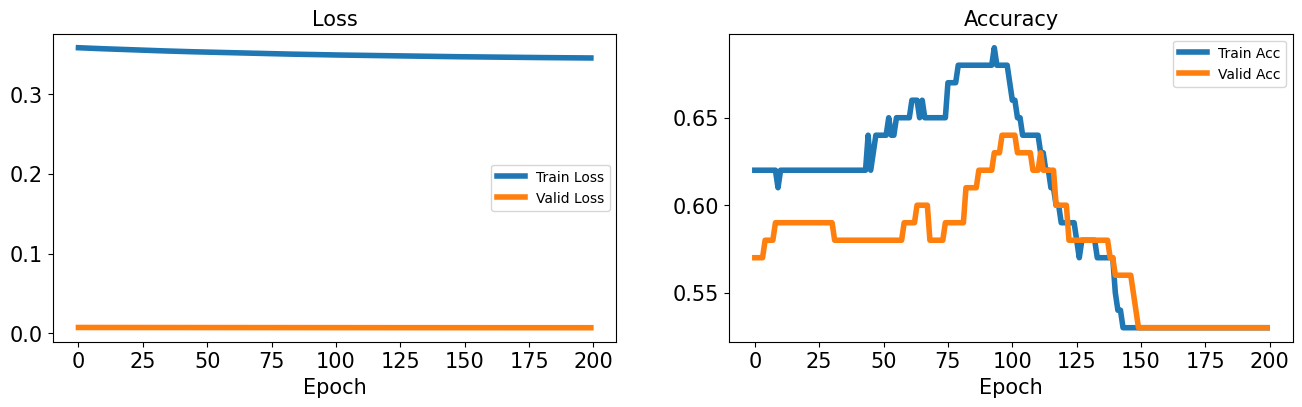

In [12]:
plot_learning_curve(loss_hist_train, accuracy_hist_train, loss_hist_valid, accuracy_hist_valid)

In [28]:
model = nn.Sequential(
    nn.Linear(2, 4),
    nn.ReLU(),
    nn.Linear(4, 4),
    nn.ReLU(),
    nn.Linear(4, 1),
    nn.Sigmoid()
)

# Define the loss function
loss_fn = nn.BCELoss()

# Define the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)

In [32]:
loss_hist_train, accuracy_hist_train, loss_hist_valid, accuracy_hist_valid = fit_model(model, 
    train_ds, 
    loss_fn, 
    optimizer,
    x_valid_ts,
    y_valid_ts,
    batch_size=2,
    num_epochs = 200,
    accuracy_fn=accuracy_sum_binaryclass_fn,
    transform_pred=transform_pred_binary)

Train loss: 0.07823 | Train accuracy: 0.93% | Val loss: 0.25884 | Val accuracy: 0.89%
Train loss: 0.06401 | Train accuracy: 0.95% | Val loss: 0.22103 | Val accuracy: 0.91%
Train loss: 0.05506 | Train accuracy: 0.95% | Val loss: 0.20355 | Val accuracy: 0.92%
Train loss: 0.04743 | Train accuracy: 0.97% | Val loss: 0.16724 | Val accuracy: 0.93%
Train loss: 0.03894 | Train accuracy: 0.98% | Val loss: 0.14726 | Val accuracy: 0.94%
Train loss: 0.03310 | Train accuracy: 0.99% | Val loss: 0.13555 | Val accuracy: 0.94%
Train loss: 0.03017 | Train accuracy: 0.98% | Val loss: 0.11695 | Val accuracy: 0.93%
Train loss: 0.02550 | Train accuracy: 1.00% | Val loss: 0.10615 | Val accuracy: 0.95%
Train loss: 0.02242 | Train accuracy: 0.99% | Val loss: 0.10253 | Val accuracy: 0.96%
Train loss: 0.02304 | Train accuracy: 0.99% | Val loss: 0.09133 | Val accuracy: 0.96%
Train loss: 0.02028 | Train accuracy: 0.99% | Val loss: 0.08648 | Val accuracy: 0.95%
Train loss: 0.01695 | Train accuracy: 0.99% | Val loss

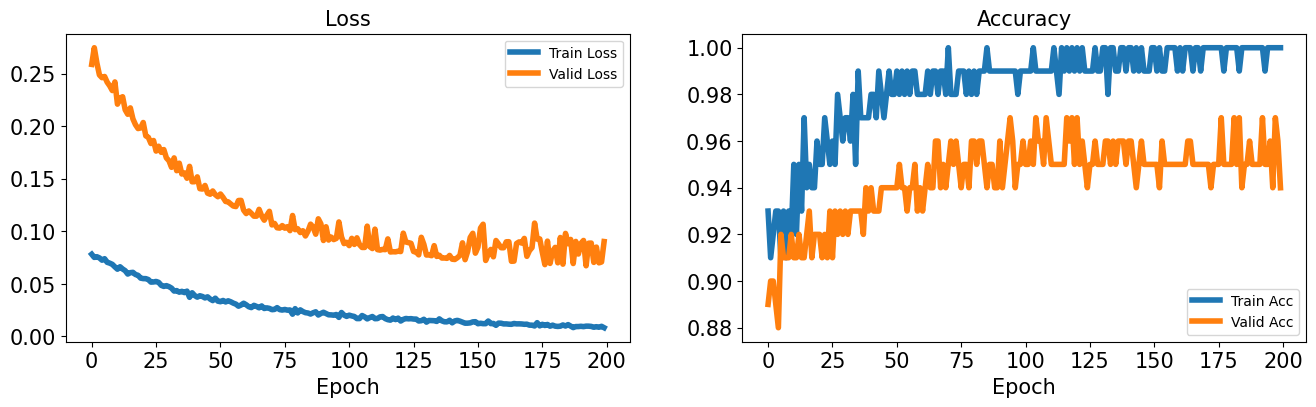

In [33]:
plot_learning_curve(loss_hist_train, accuracy_hist_train, loss_hist_valid, accuracy_hist_valid)

In [20]:
def evaluate_model(model: torch.nn.Module,
                    x_test: torch.Tensor,
                    y_test: torch.Tensor,
                    score_fn,
                    transform_pred = None,
                    device: torch.device = "cpu"):
    # set to device
    model.to(device)
    x_test, y_test = x_test.to(device), y_test.to(device)
    # logic
    y_pred = model(x_test)
    if transform_pred:
        y_pred = transform_pred(y_pred)
    score = score_fn(y_pred, y_test)
    score = score / len(y_test)
    # result
    return score

In [34]:
score = evaluate_model(model, x_valid_ts, y_valid_ts, accuracy_sum_binaryclass_fn, transform_pred=transform_pred_binary)
print(score)

tensor(0.9400)


In [42]:
def predict_binaryclass_fn(y_pred, threshold = 0.5):
    return (y_pred >= threshold).float()

In [43]:
y_pred = model(x_valid_ts[:2])
print(y_pred)
y_pred = transform_pred_binary(y_pred)
print(y_pred)
y_pred = predict_binaryclass_fn(y_pred)
print(y_pred)
print(y_valid_ts[:2])

tensor([[4.6392e-07],
        [1.3632e-09]], grad_fn=<SigmoidBackward0>)
tensor([4.6392e-07, 1.3632e-09], grad_fn=<SqueezeBackward0>)
tensor([0., 0.])
tensor([0., 0.])
